## Project Configuration

In [1]:
from scvi_colab import install
install(run_outside_colab=True)

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


In [137]:
import os
import tempfile

import anndata
import muon
import numpy as np
import pooch
import scanpy as sc
import scvi 
import seaborn as sns
import torch
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt

In [179]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")

#Change to Ouputs when done
save_dir = 'C:/Users/chpar/OneDrive/Documents/GitHub/Summer2024Caleb/Assignment_1_SCVI_Tool/Saved_Model'

#Inputs:
BATCHES_CSV_PATH = "Test_Paths.csv"
N_TOP_GENES = 1200
OUTPUT_PATH = "Outputs"


#Variable equivalencies between tutorial and actual
#Tutorial Name:          Actual Name:
#"cell_source"              "batch"


In [4]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.2


## Loading Data from CSV Paths

In [322]:
df = pd.read_csv(BATCHES_CSV_PATH)
batches = df.to_dict(orient="index")

# Get dataframe labels from CSV file
csv_labels = df.columns.to_list()

batches


{0: {'path': 'C:\\Users\\chpar\\OneDrive\\Documents\\GitHub\\Summer2024Caleb\\Assignment_1_SCVI_Tool\\40_10X_GZ',
  'label': ' "test1"'},
 1: {'path': 'C:\\Users\\chpar\\OneDrive\\Documents\\GitHub\\Summer2024Caleb\\Assignment_1_SCVI_Tool\\47_10X_GZ',
  'label': ' "test2"'}}

In [323]:
print(batches.items())
print (csv_labels)

dict_items([(0, {'path': 'C:\\Users\\chpar\\OneDrive\\Documents\\GitHub\\Summer2024Caleb\\Assignment_1_SCVI_Tool\\40_10X_GZ', 'label': ' "test1"'}), (1, {'path': 'C:\\Users\\chpar\\OneDrive\\Documents\\GitHub\\Summer2024Caleb\\Assignment_1_SCVI_Tool\\47_10X_GZ', 'label': ' "test2"'})])
['path', 'label']


In [324]:
adatas = {}

for batch in batches.items():
    path = batch[1][csv_labels[0]]
    batch_label = batch[1][csv_labels[1]]

    batch_adata = sc.read_10x_mtx(path)
    batch_adata.var.add_suffix(suffix=batch_label) 
    adatas[batch_label] = batch_adata

adata = ad.concat(adatas, label="batch")
adata.obs_names_make_unique()

adata

c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 5373 × 36601
    obs: 'batch'

In [325]:
print(adata.obs.sample(n=5))

                       batch
GGATGTTGTCTGCAAT-1   "test1"
ATCCTATCAAGCGGAT-1   "test1"
GACCTTCCACAGTCAT-1   "test2"
GACTATGTCTAGAACC-1   "test2"
GCTTCACGTCAGTCTA-1   "test1"


In [326]:
adata


AnnData object with n_obs × n_vars = 5373 × 36601
    obs: 'batch'

## Loading Data from Tutorial

In [71]:
adata = scvi.data.heart_cell_atlas_subsampled(save_path=save_dir)
adata

INFO     File                                                                                                      
         C:/Users/chpar/OneDrive/Documents/GitHub/Summer2024Caleb/Assignment_1_SCVI_Tool/Saved_Model\hca_subsampled
         _20k.h5ad already downloaded                                                                              


AnnData object with n_obs × n_vars = 18641 × 26662
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    uns: 'cell_type_colors'

## Preprocessing Data

In [327]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [328]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

In [329]:
print("# cells, # genes before filtering:", adata.shape)

sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

print("# cells, # genes after filtering:", adata.shape)

# cells, # genes before filtering: (5373, 36601)
# cells, # genes after filtering: (5373, 21560)


In [330]:
#Save counts information before normalizing
adata.layers["counts"] = adata.X.copy()

In [331]:

#Normalization of data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

#store normalized values in .raw
adata.raw = adata

In [336]:
adata.obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 5373 × 1200
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', '_scvi_batch', '_scvi_labels'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg'
    obsm: '_scvi_extra_categorical_covs'
    layers: 'counts'>

In [332]:
# Identify highly variable ggenes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=N_TOP_GENES,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="batch",
)


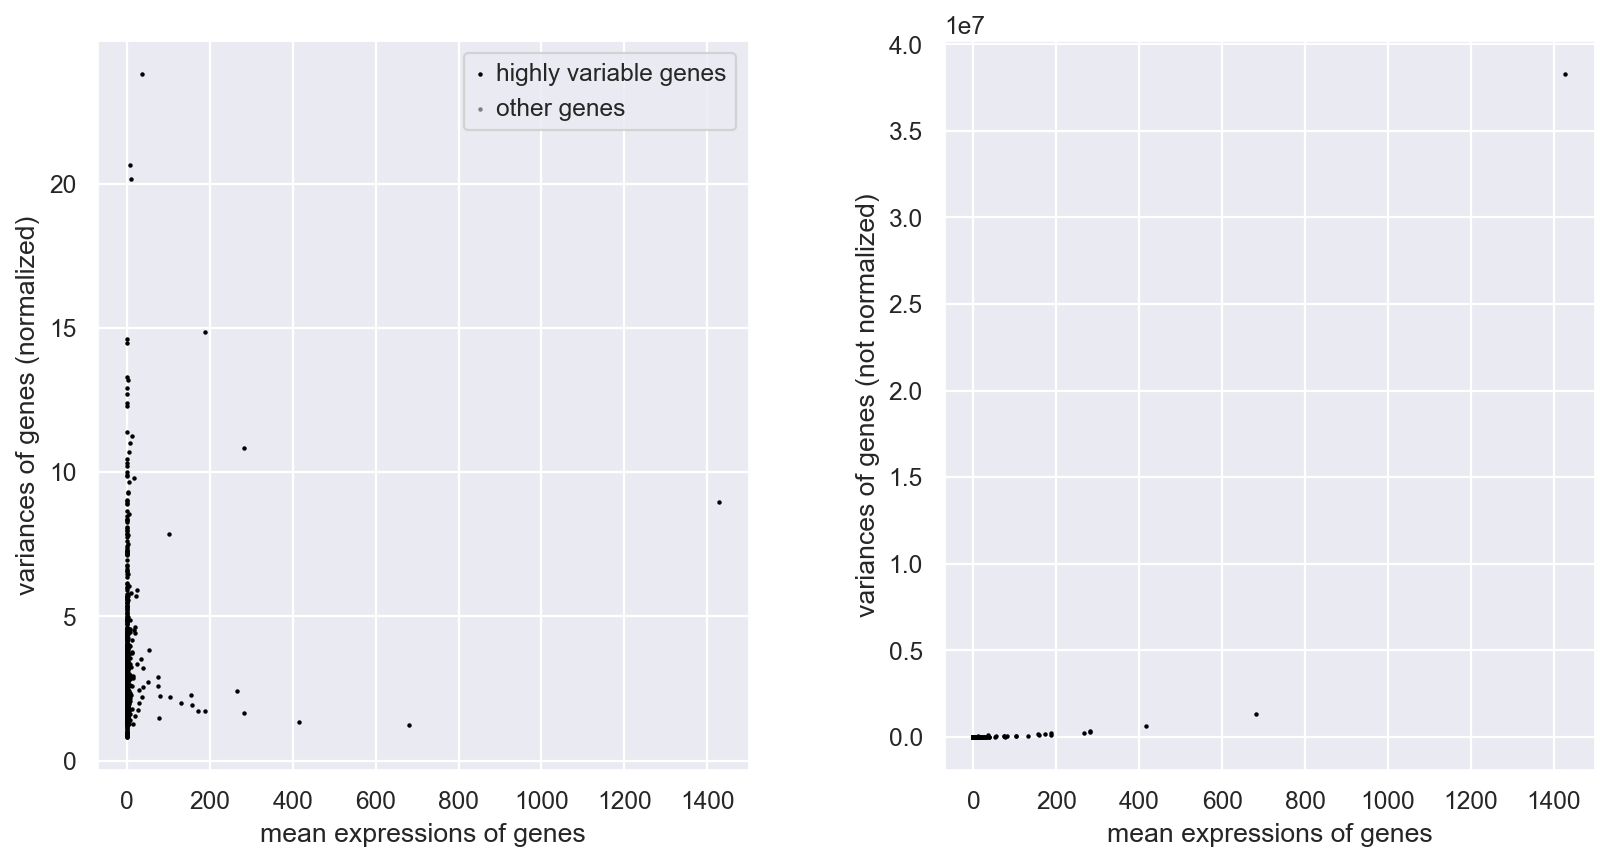

In [333]:
sc.pl.highly_variable_genes(adata)

## Running SCVI Model

In [337]:
scvi.model.SCVI.setup_anndata(
    adata, 
    layer="counts", 
    categorical_covariate_keys=["batch"],
    continuous_covariate_keys=["pct_counts_mt", "pct_counts_ribo"],
    batch_key="batch")

model = scvi.model.SCVI(adata)

In [338]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [339]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [15:53<00:00,  2.09s/it, v_num=1, train_loss_step=555, train_loss_epoch=548]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [15:53<00:00,  2.38s/it, v_num=1, train_loss_step=555, train_loss_epoch=548]


## Save/Load Model

In [340]:
model_dir = save_dir 
#model.save(save_dir, overwrite=True)   

In [341]:
#Run to load model from save
model_dir = save_dir 
model = scvi.model.SCVI.load(model_dir, adata=adata)

INFO     File C:/Users/chpar/OneDrive/Documents/GitHub/Summer2024Caleb/Assignment_1_SCVI_Tool/Saved_Model\model.pt 
         already downloaded                                                                                        


c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-packages\scvi\model\base\_base_model.py:683: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  _validate_var_names(adata, var_names)


In [342]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

## Obtaining Outputs

In [343]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(5373, 10)

In [344]:
SCVI_NORMALIZED_KEY = "scvi_normalized"
adata.layers[SCVI_NORMALIZED_KEY] = model.get_normalized_expression(library_size=10e4)

#### Visualization without Batch Correction

In [414]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

sc.tl.leiden(adata, resolution=0.3)

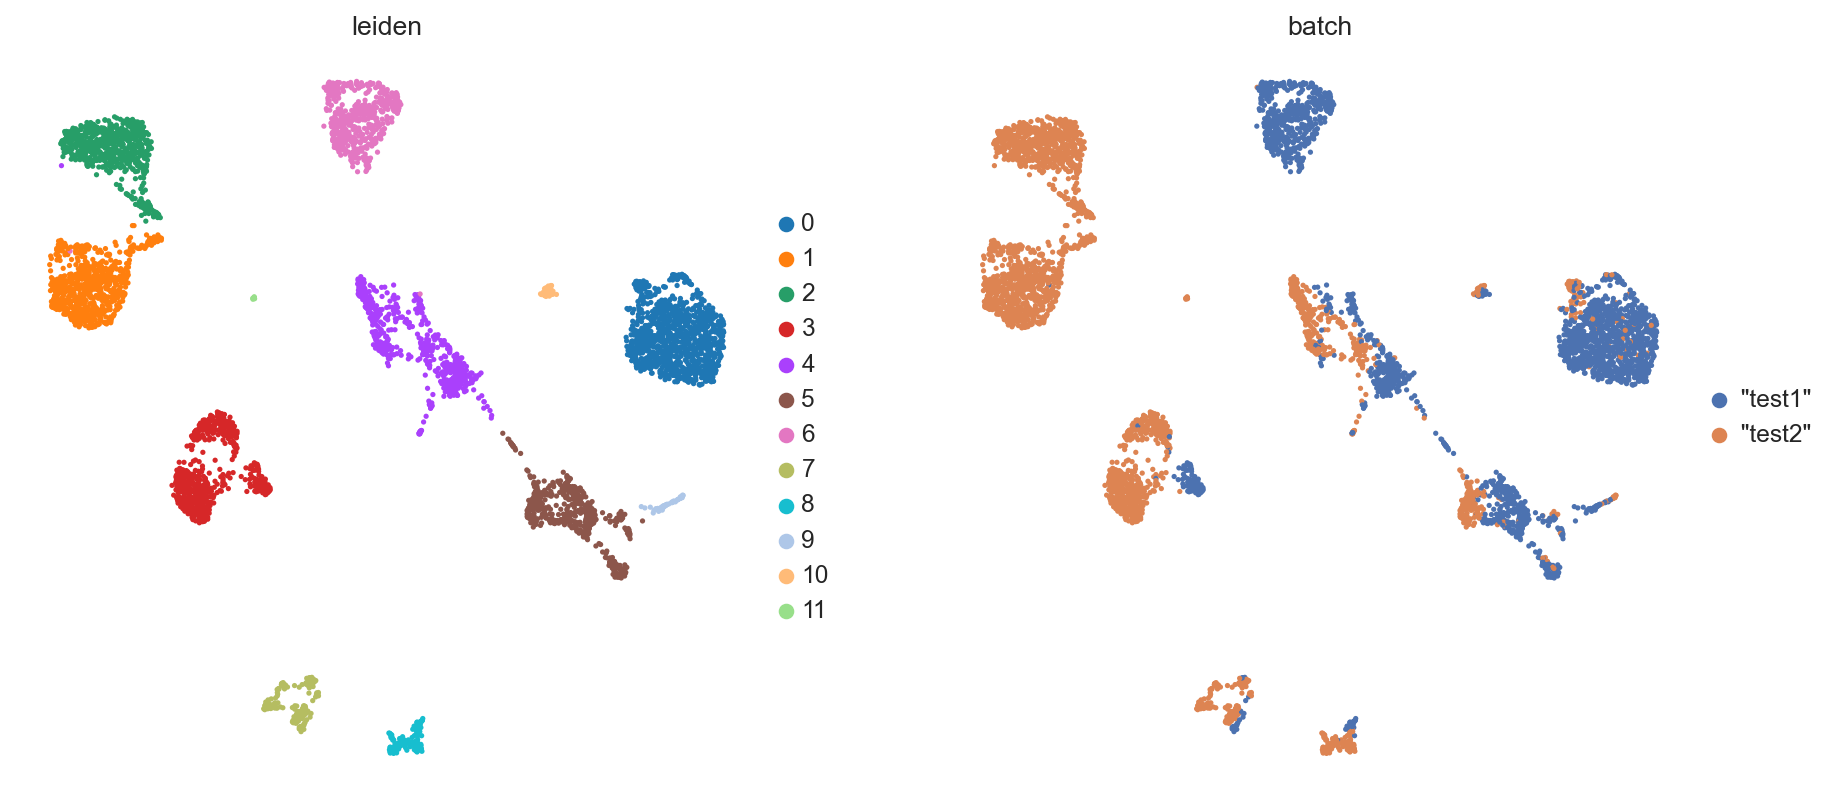

In [370]:
np.random.seed(0)
random_indices = np.random.permutation(list(range(adata.shape[0])))

sc.pl.umap(
    adata[random_indices, :],
    color=["leiden", "batch"],
    ncols=2,
    frameon=False,
)

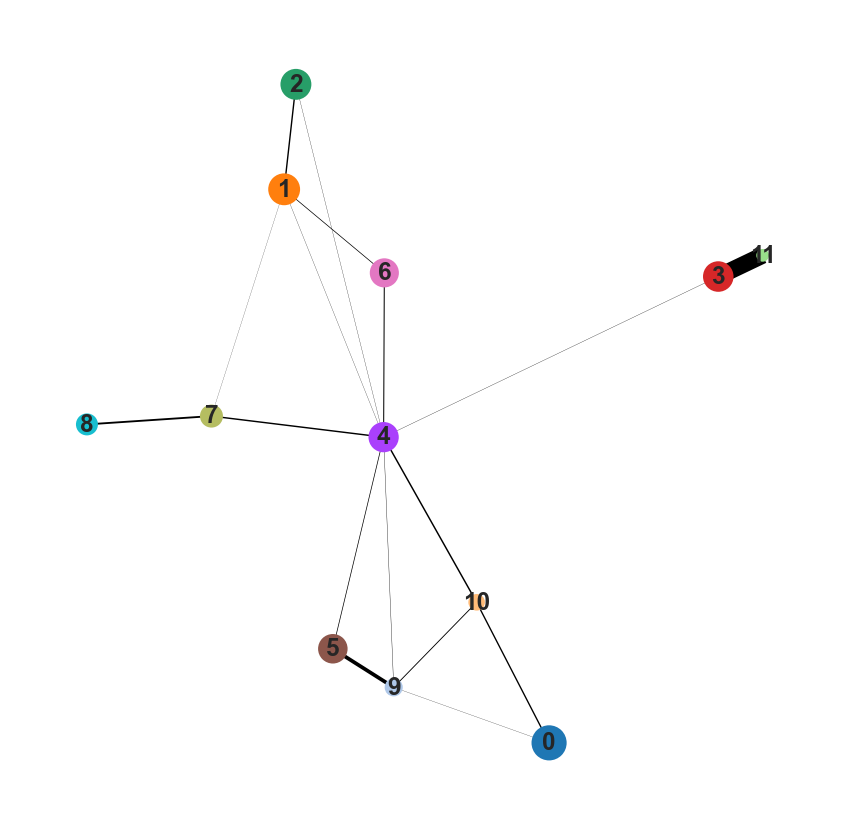

In [371]:
sc.tl.paga(adata, groups="leiden") # change groups to the name of the clusters

sc.pl.paga(adata)

In [372]:
adata.obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 5373 × 1200
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', '_scvi_batch', '_scvi_labels', 'leiden', 'leiden_scVI'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_colors', 'leiden_scVI', 'leiden_scVI_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', '

#### Visualization with batch correction

In [430]:
#Use scVI latent space for UMAP
sc.pp.neighbors(adata, n_pcs=10, n_neighbors=20) #, use_rep=SCVI_LATENT_KEY
sc.tl.umap(adata, min_dist=0.3)

In [431]:
SCVI_CLUSTERS_KEY = "leiden_scVI"
sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.05)

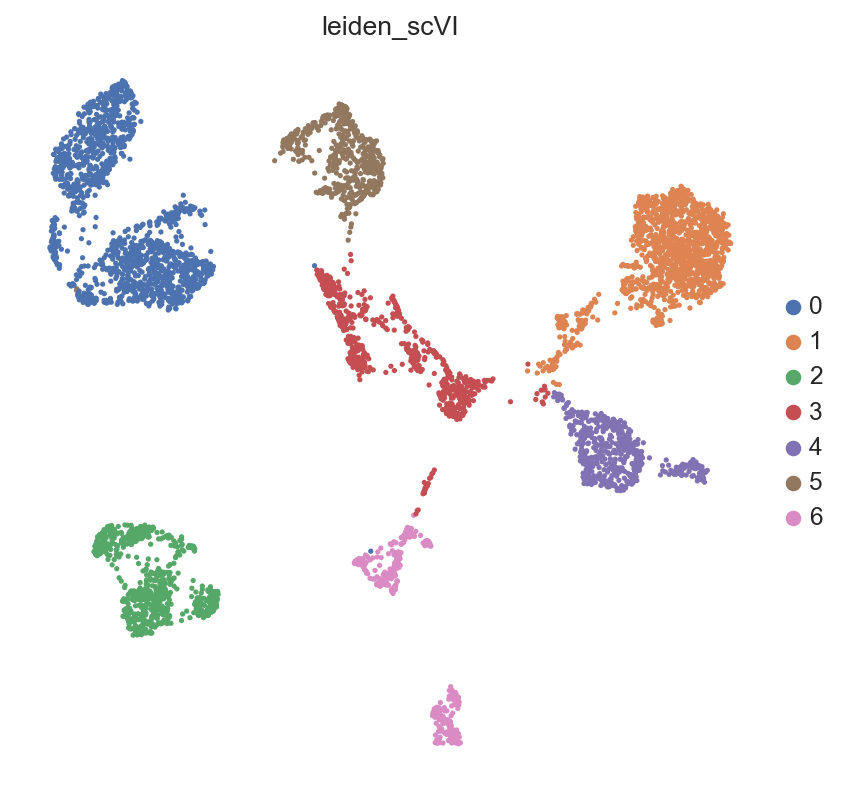

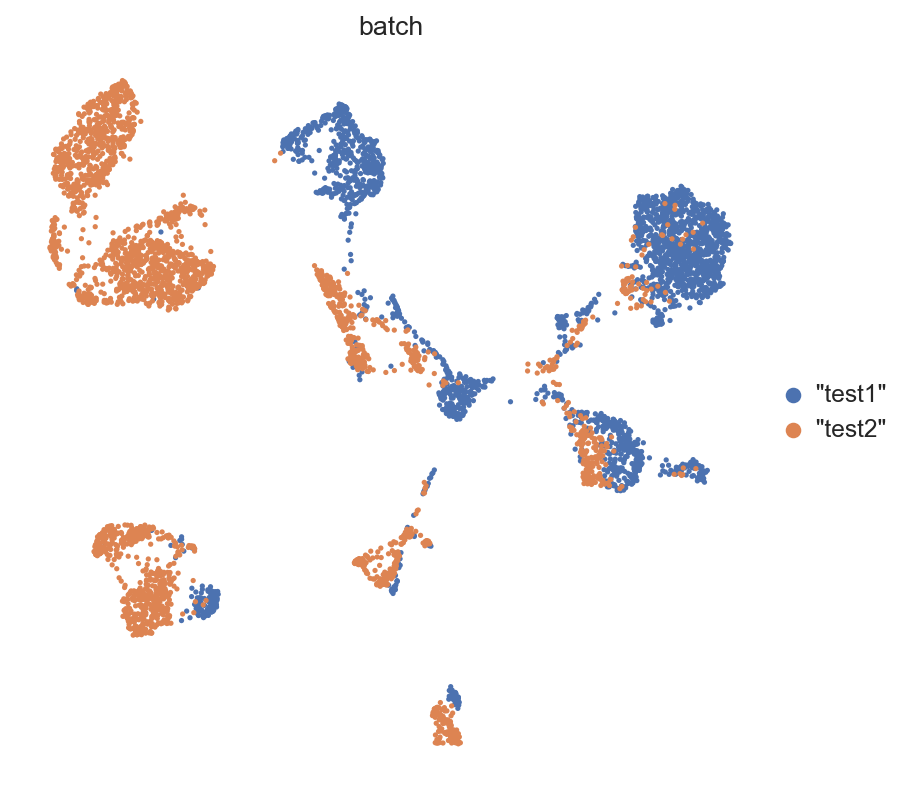

In [432]:
sc.pl.umap(
    adata,
    color=[SCVI_CLUSTERS_KEY],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["batch"],
    ncols=2,
    frameon=False,
)

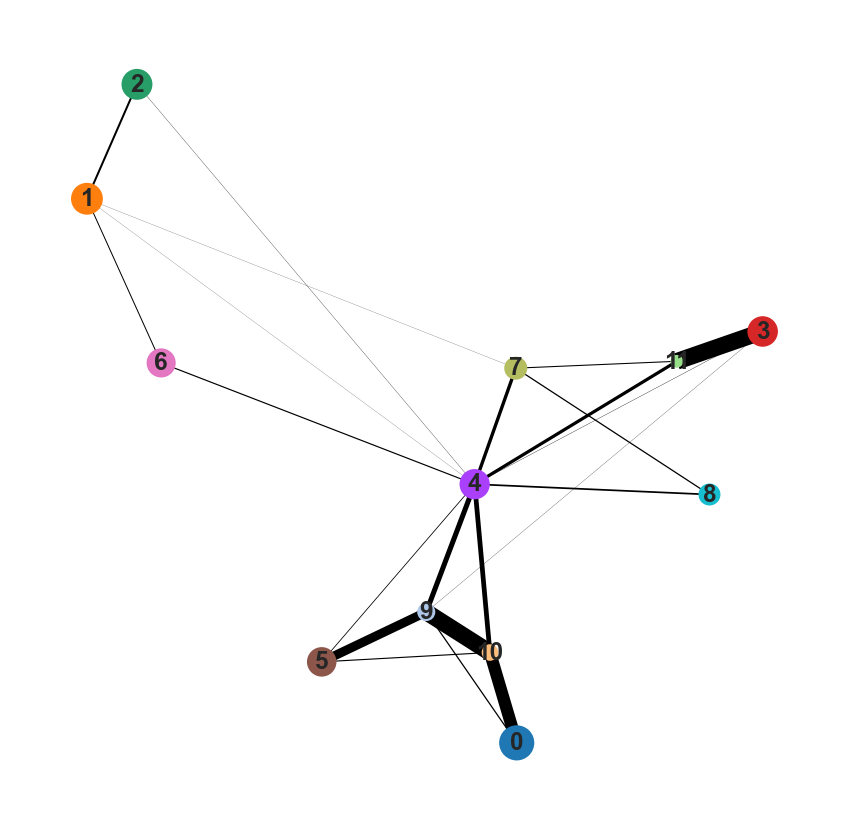

In [448]:
sc.tl.paga(adata, groups="leiden") # change groups to the name of the clusters

sc.pl.paga(adata)

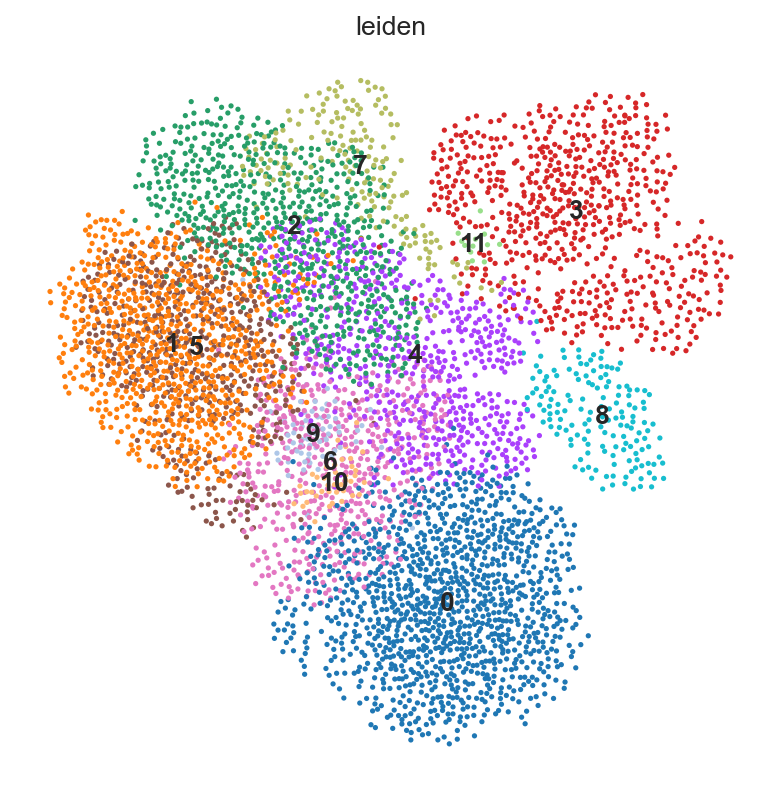

In [449]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123, layout='fa')
sc.pl.draw_graph(adata, color=["leiden"], legend_loc='on data') # plotting

In [354]:
adata.var_keys

<bound method AnnData.var_keys of AnnData object with n_obs × n_vars = 5373 × 1200
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', '_scvi_batch', '_scvi_labels', 'leiden', 'leiden_scVI'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_colors', 'leiden_scVI', 'leiden_scVI_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', '

In [385]:
markers = {"Alpha":["GCG", "LOXL4", "GC", "CRYBA2","TTR","IRX2","TM4SF4","ARX","MAFB", "PGR"], #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5092539/
           "Beta":["INS", "IAPP","MAFA","NPTX2","DLK1","TGFBR3","SYT13","SMAD9","CDKN1C","TFCP2L1","SIX3","MNX1","MBP5","PIR", "G6PC2","ADCYAP1","PDX1"], #"ADCYAP1","PDX1",#ADCYAP1#https://www.nature.com/artiMAFBcles/s41587-022-01219-z#MOESM10 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5092539/
           "New Beta":[  "SPD", "INS", "MMP-2","CK-19"],#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2842599/
            "Delta":["SST", "RBP4", "HHEX", "PCSK1", "PRG4" "BHLHE41", "LEPR"],#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5092539/
            "Acinar":["GP2", "CTRC", "AMY2A", "CPA1", "SYCN"], #https://www.nature.com/articles/s41598-019-40481-1/tables/1
            "Cancer stem cells":[ "OCT4","MYC","KLF4","SOX2"],
            "Ductal":["KRT19","SOX9"], #https://www.nature.com/articles/s41598-019-40481-1/tables/1
            "Endothelial":["CD93","ACE","CD143","C1qR1","CD31","CD34"], #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7749106/
            "Macrophages":["CD206","CD68","CD163"],
            "PP": ["PPY","ETV1","ARX","PAX6","SERTM1""CARTPT","SLITRK6"], #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5092539/
            "Pancreatic progenitor": ["CPA1","NEUROG3","NKX6.1","PTF1A","SOX9","C-MYC","SOX4","NEUROD1"], #https://www.nature.com/articles/s41467-017-00561-0
            "Additional factors": ["SOX2","OCT4","NANOG","PDX1"] 
            }

marker gene of Alpha


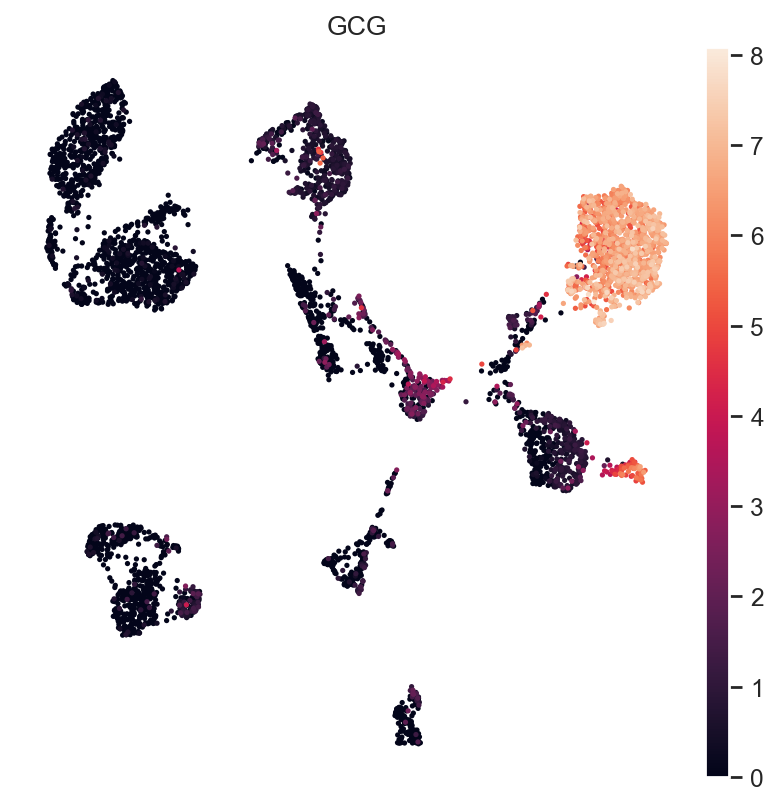

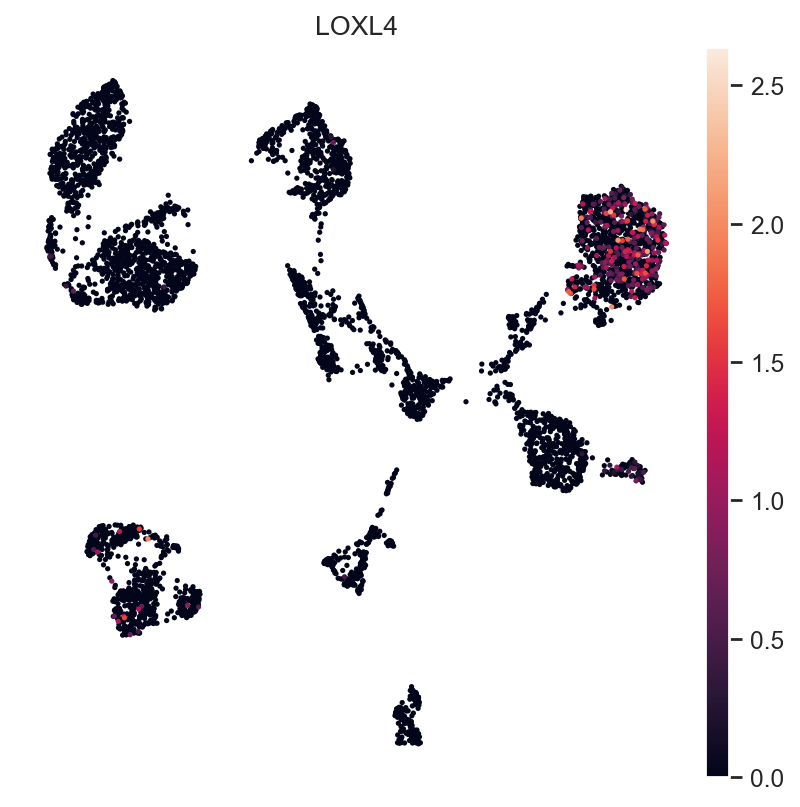

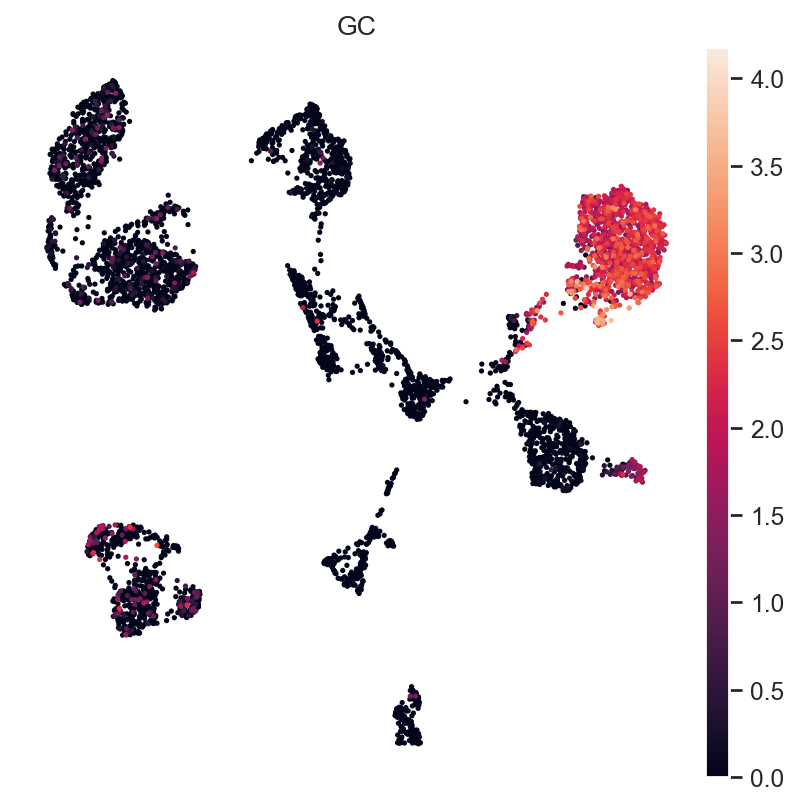

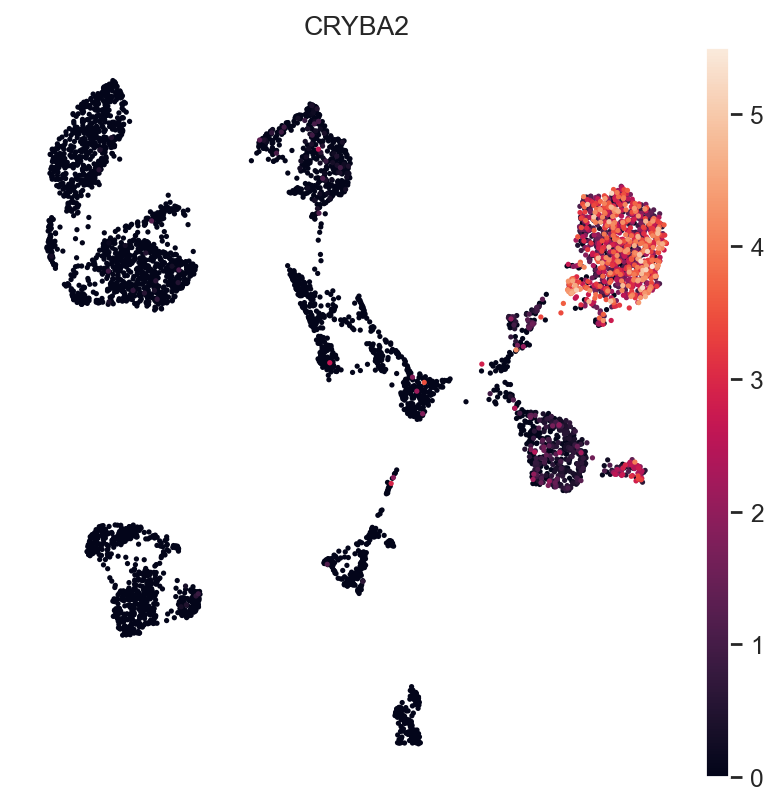

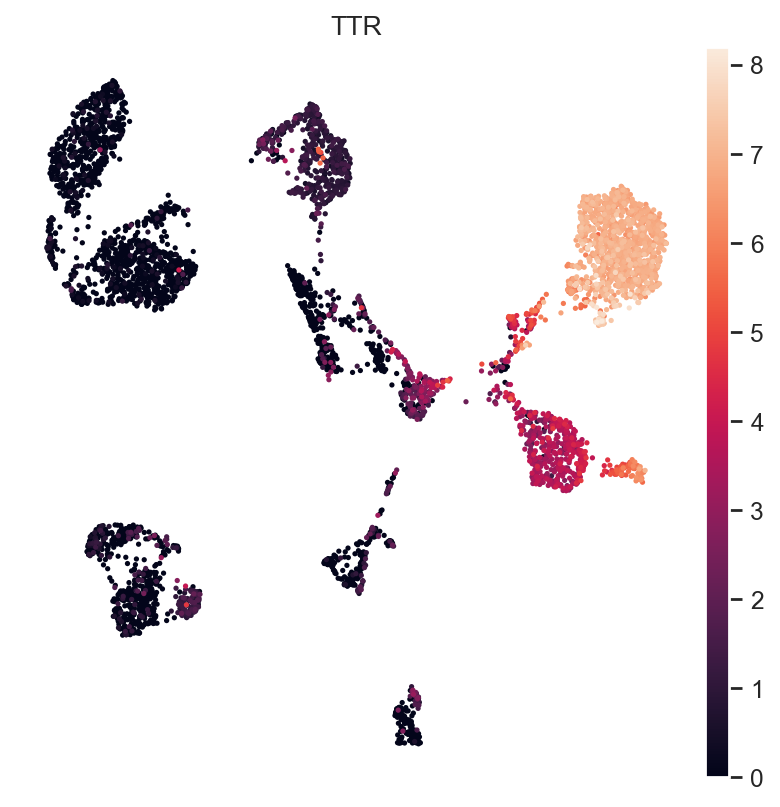

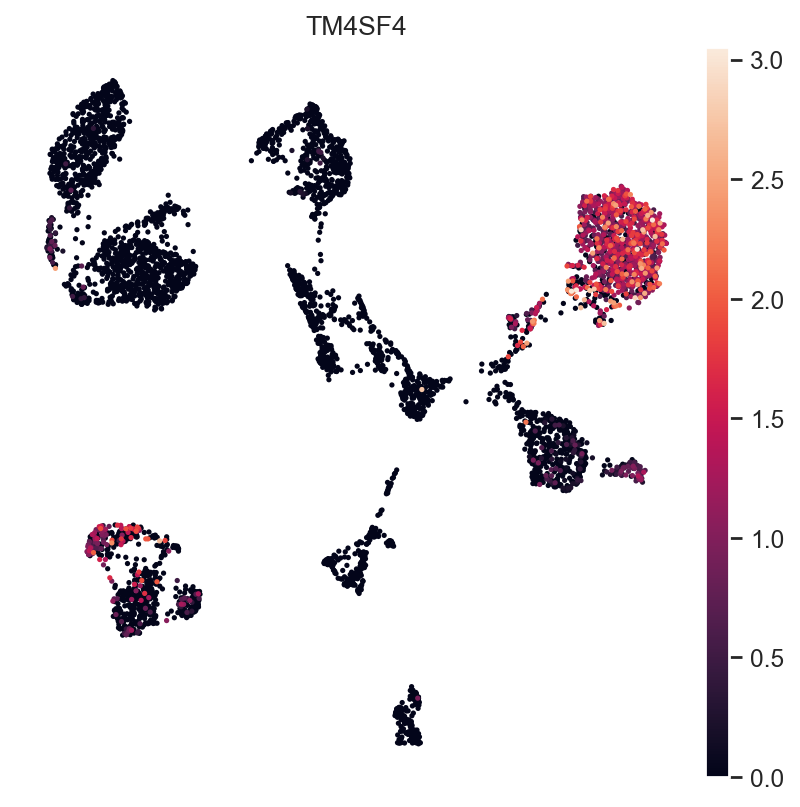

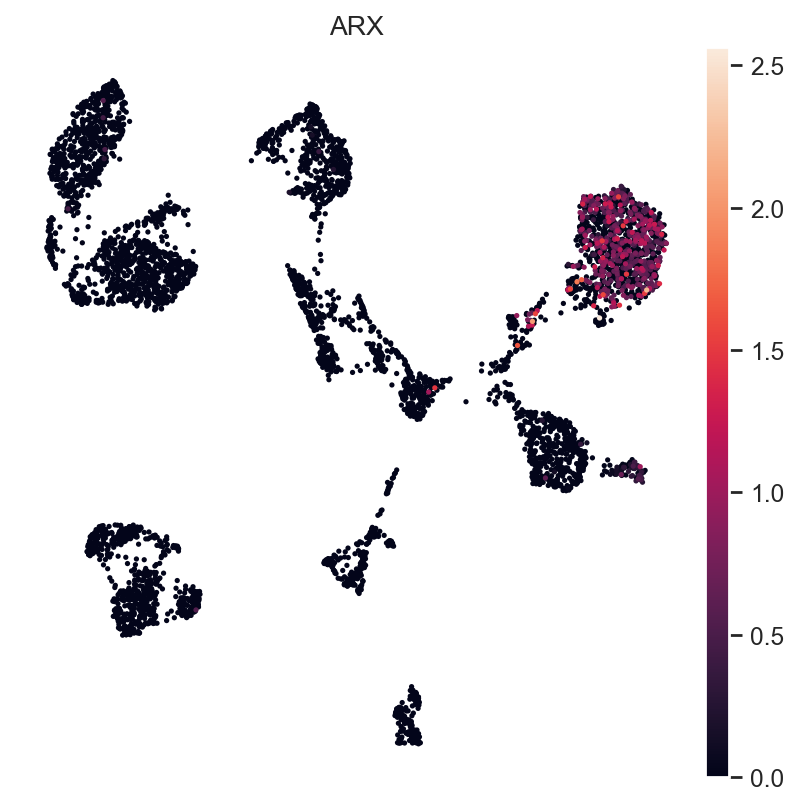

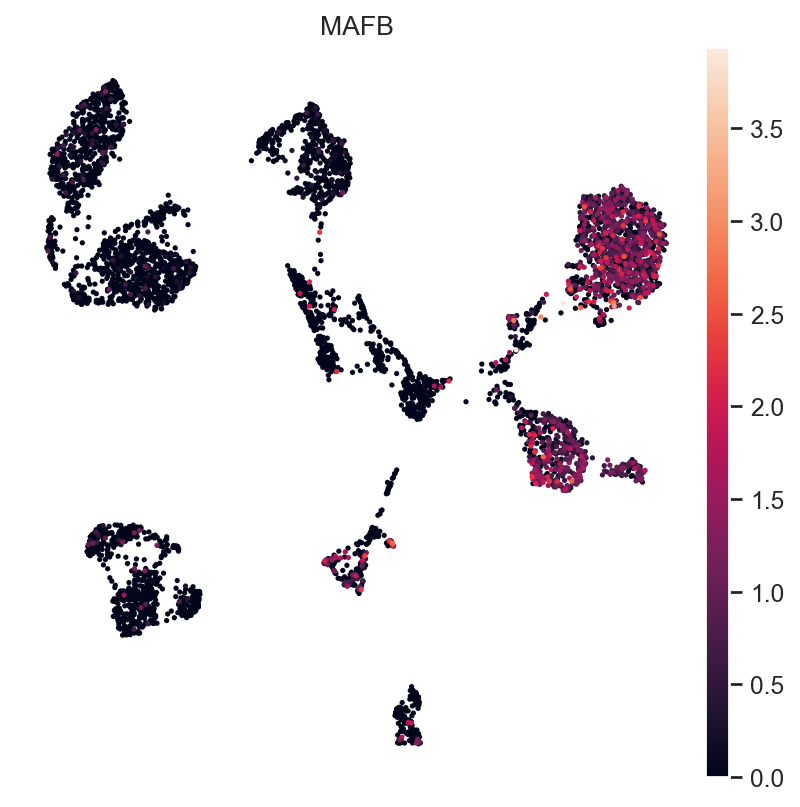

marker gene of Beta


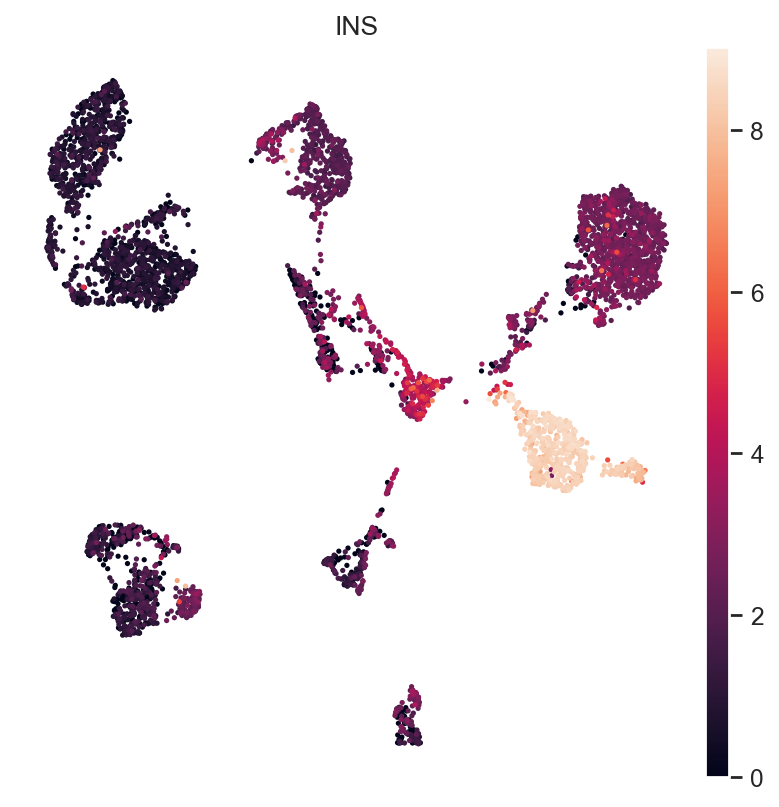

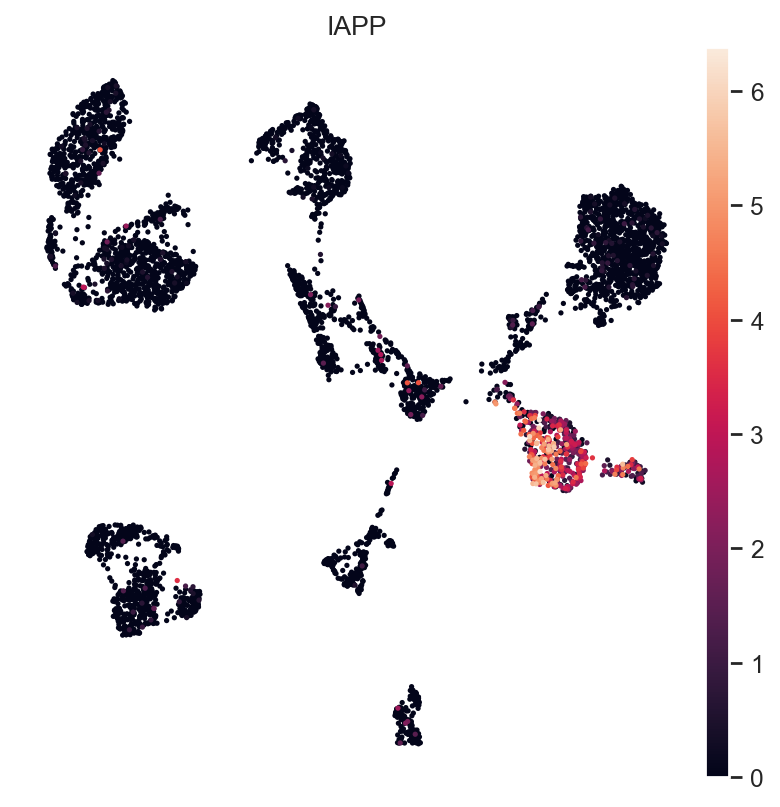

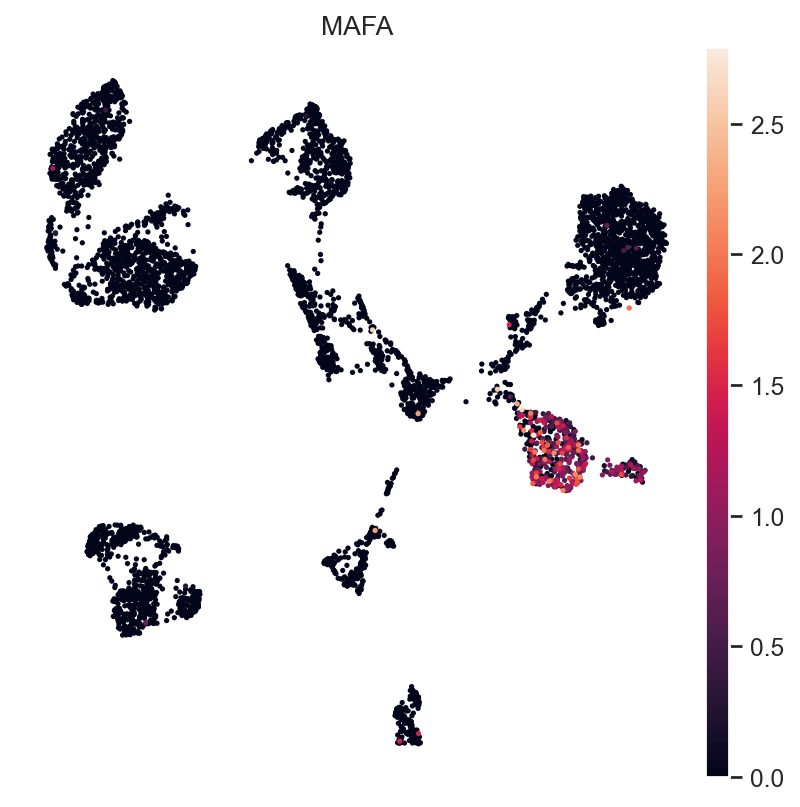

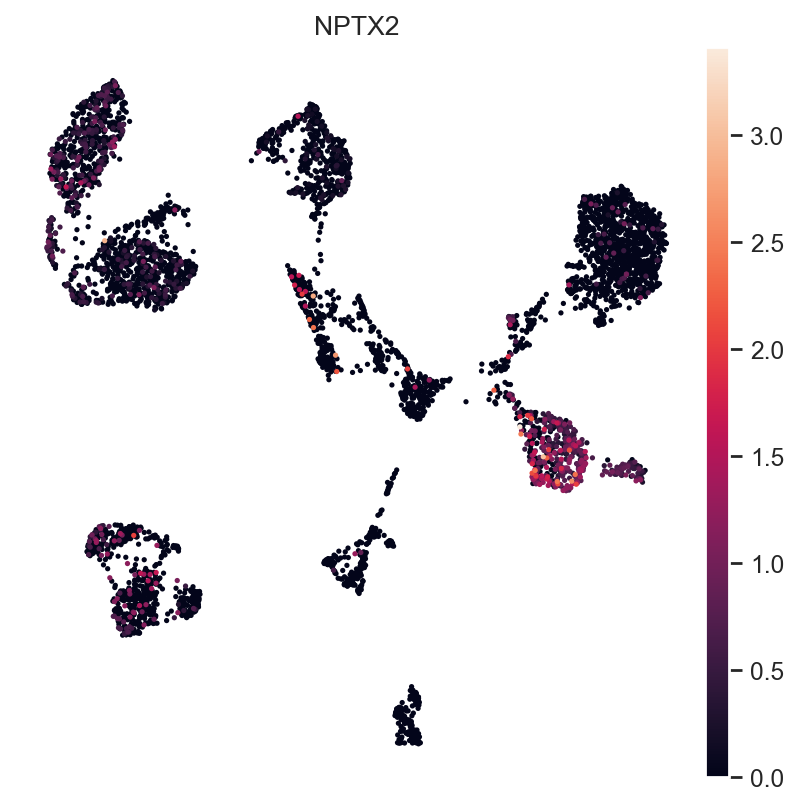

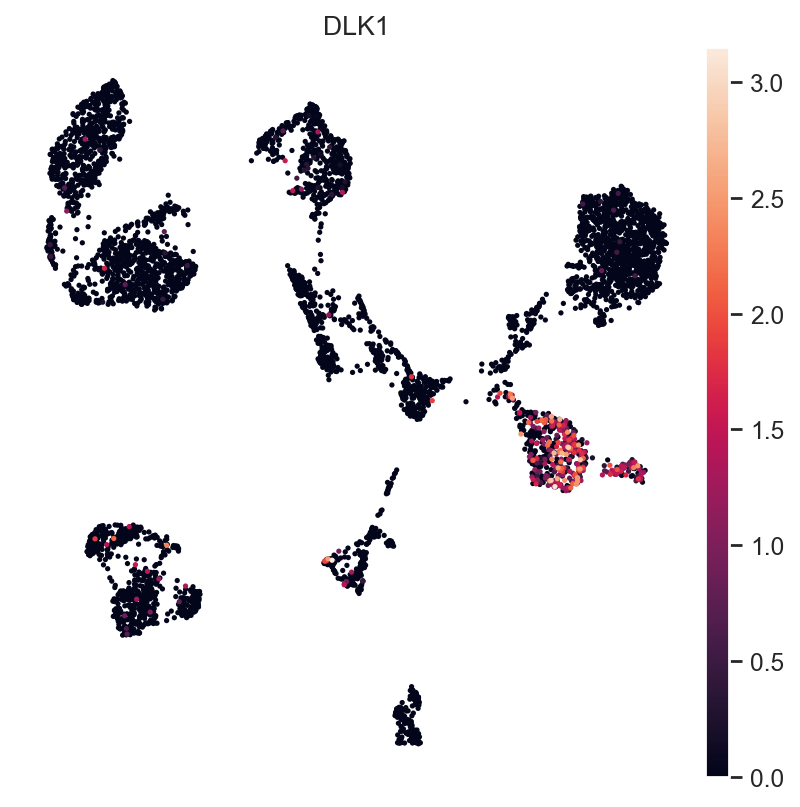

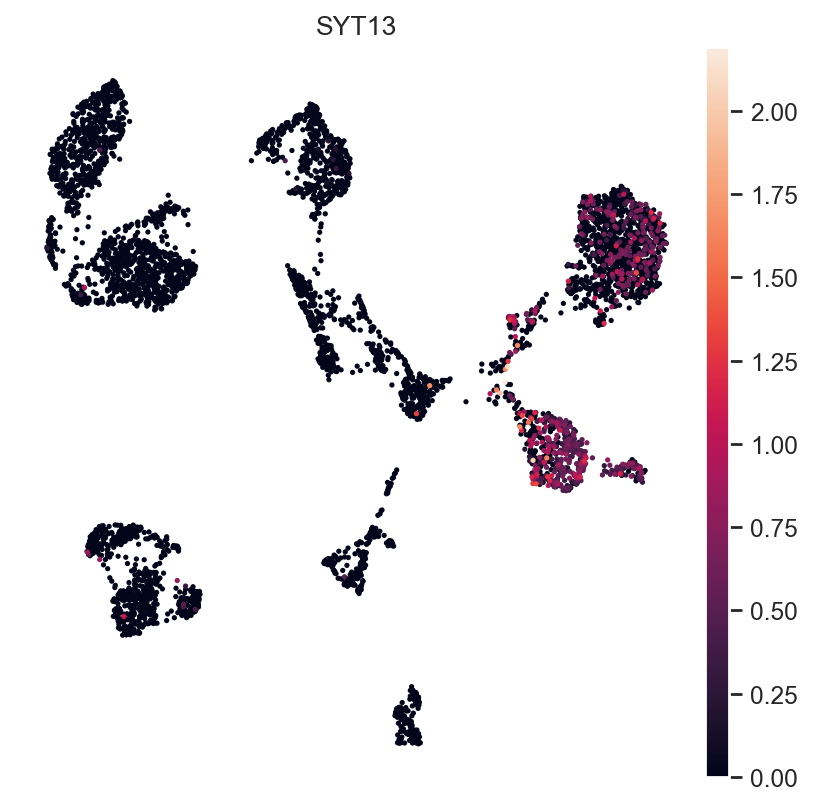

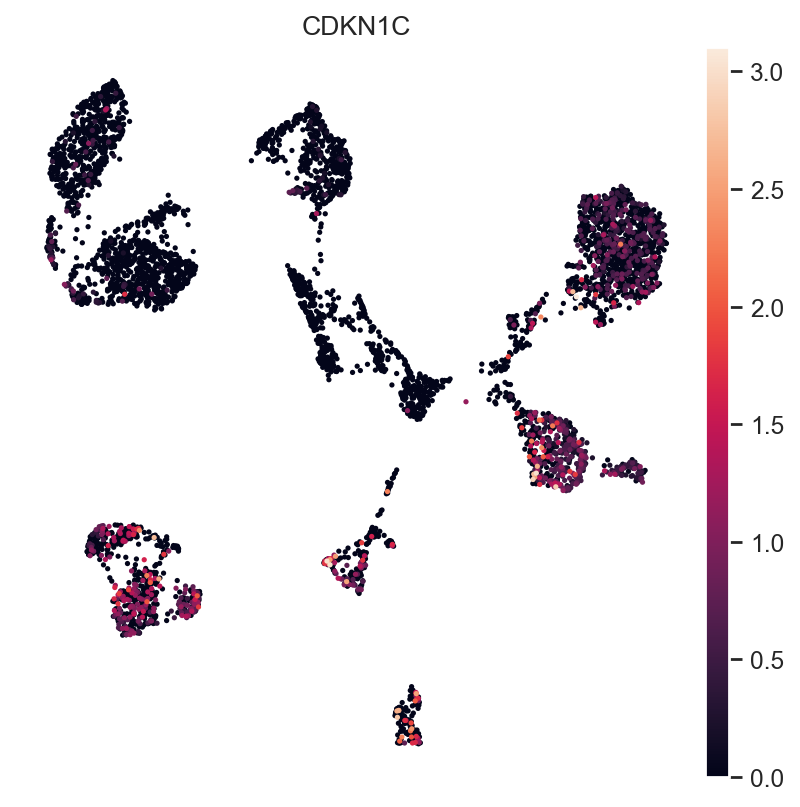

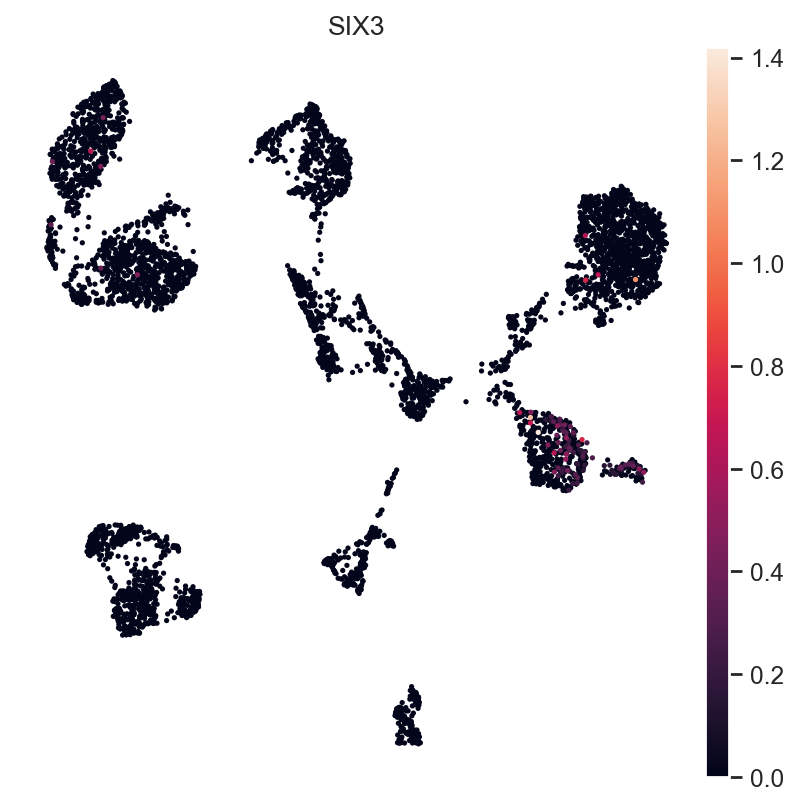

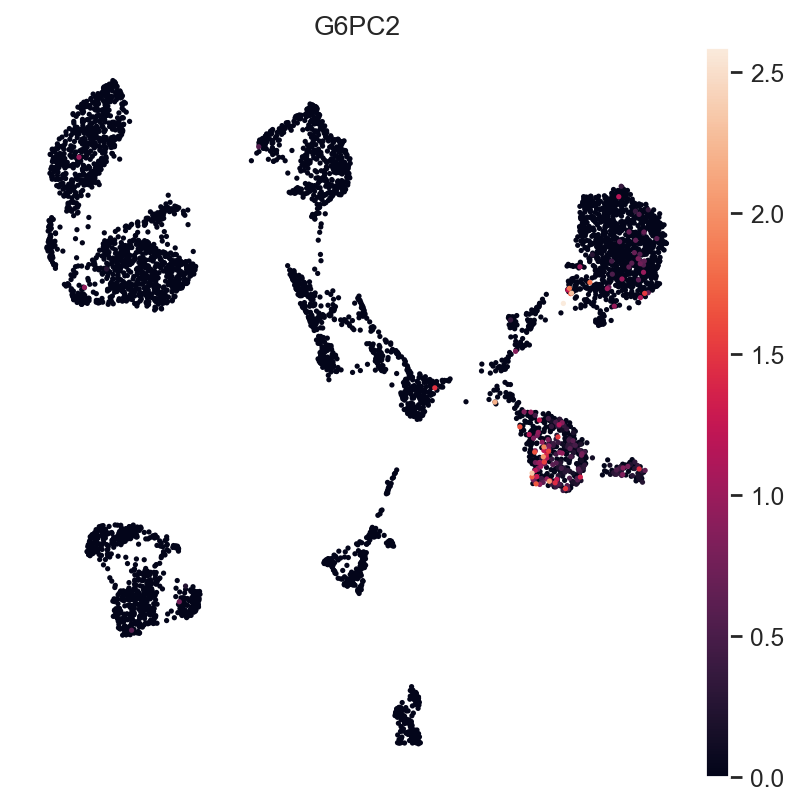

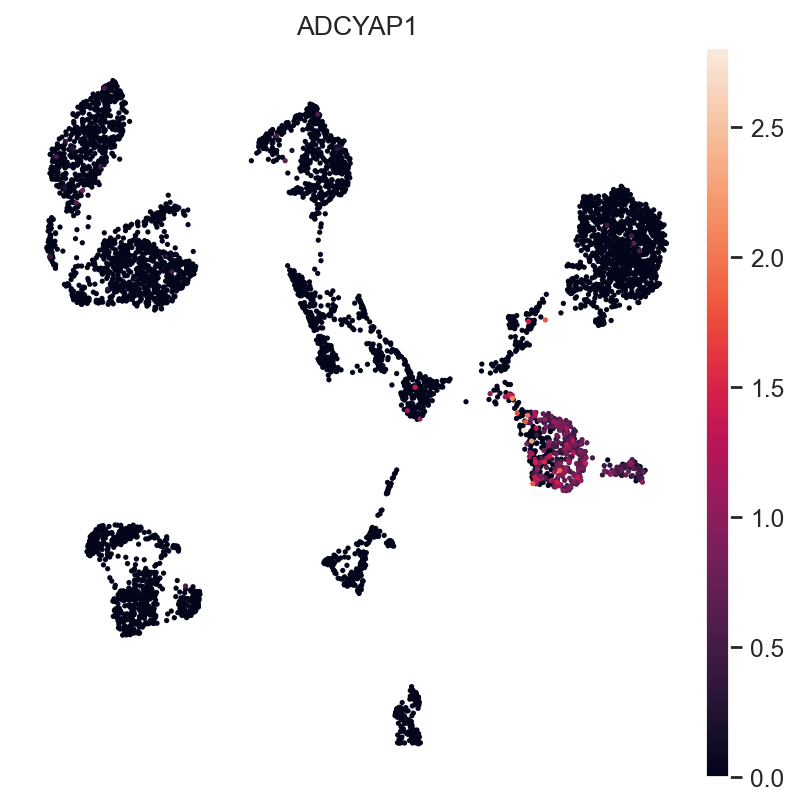

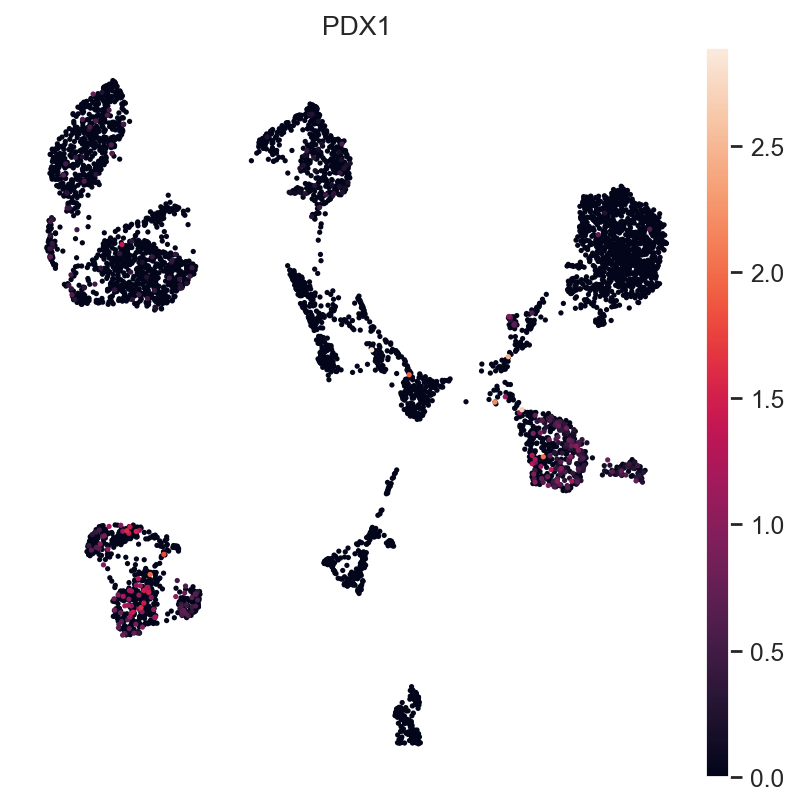

marker gene of New Beta


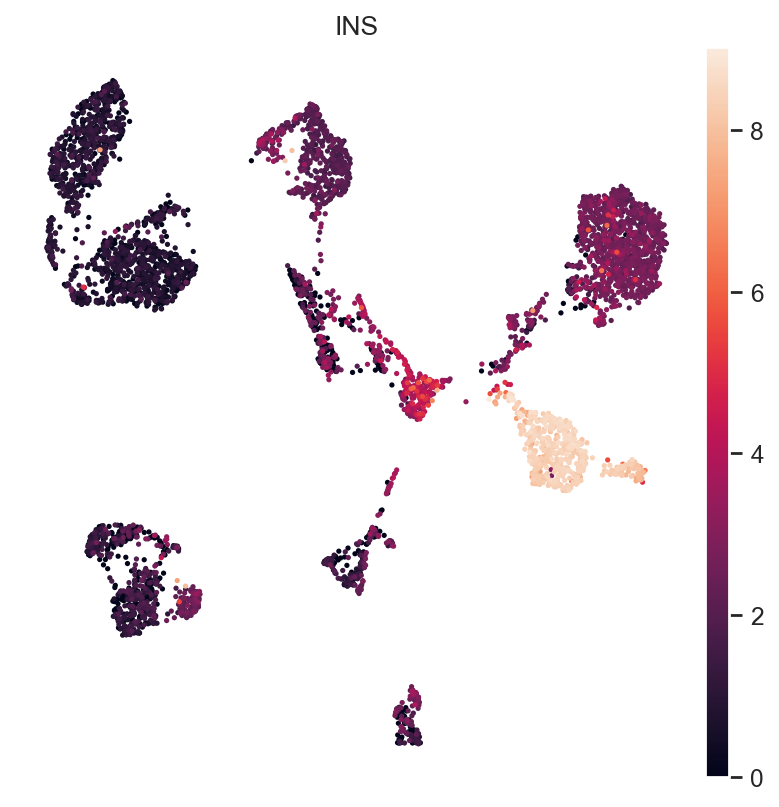

marker gene of Delta


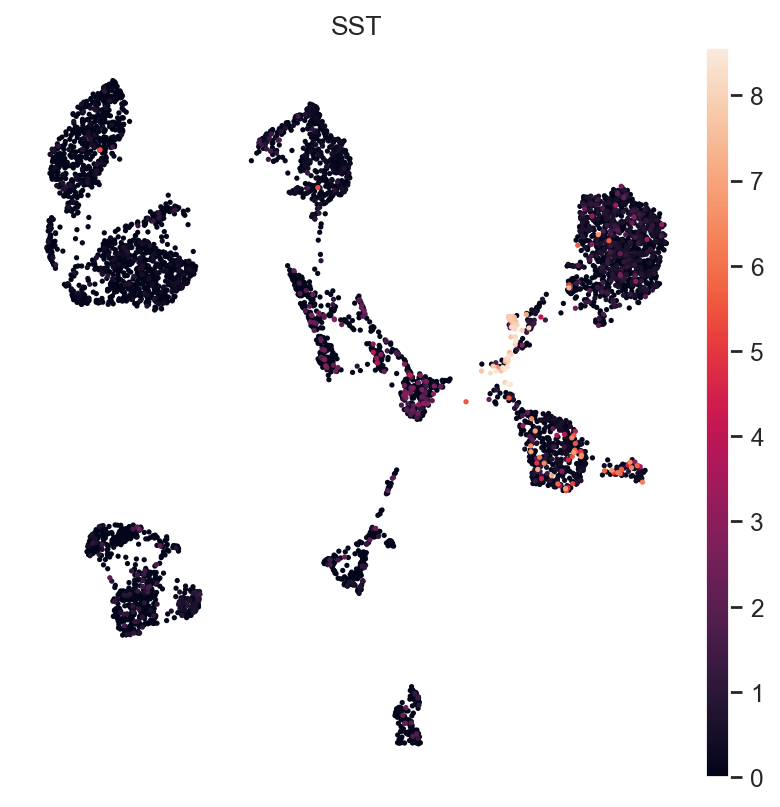

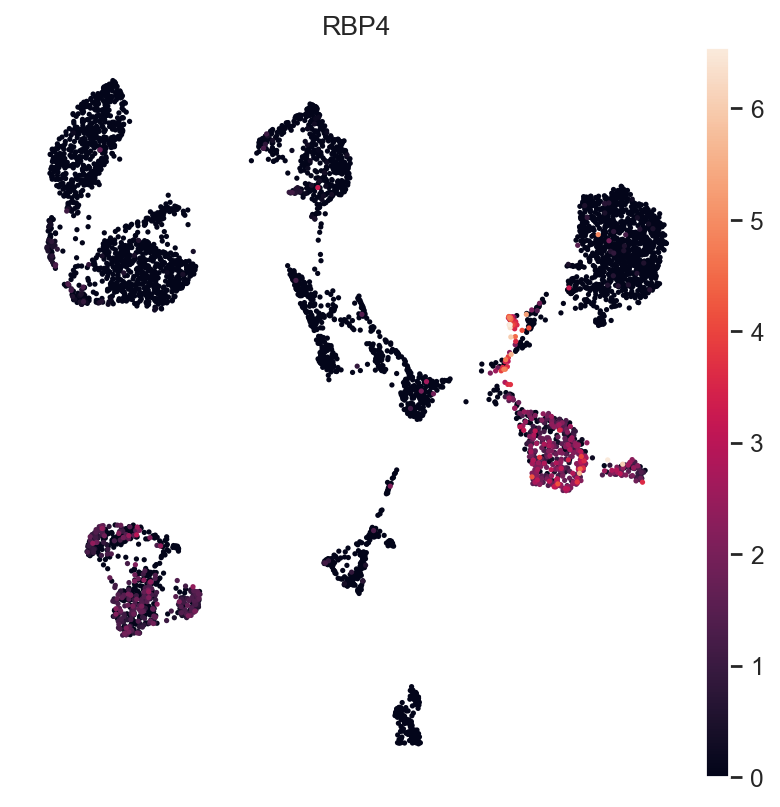

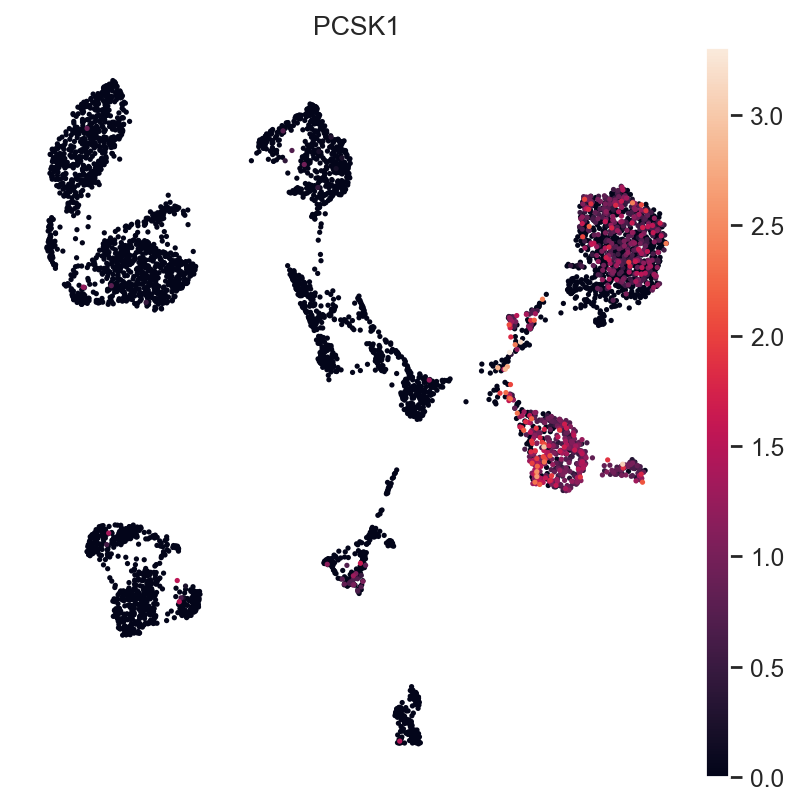

marker gene of Acinar


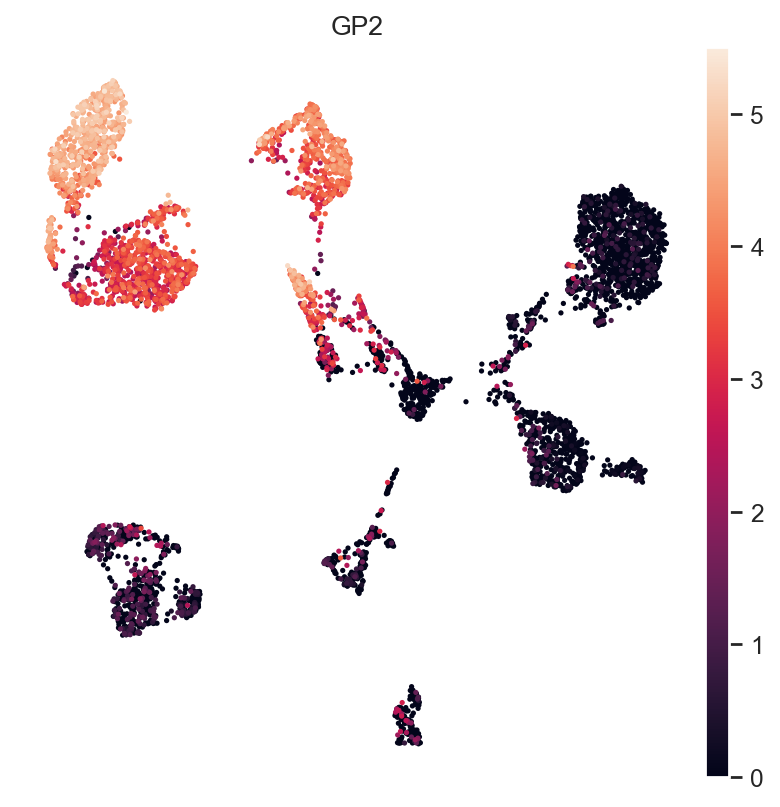

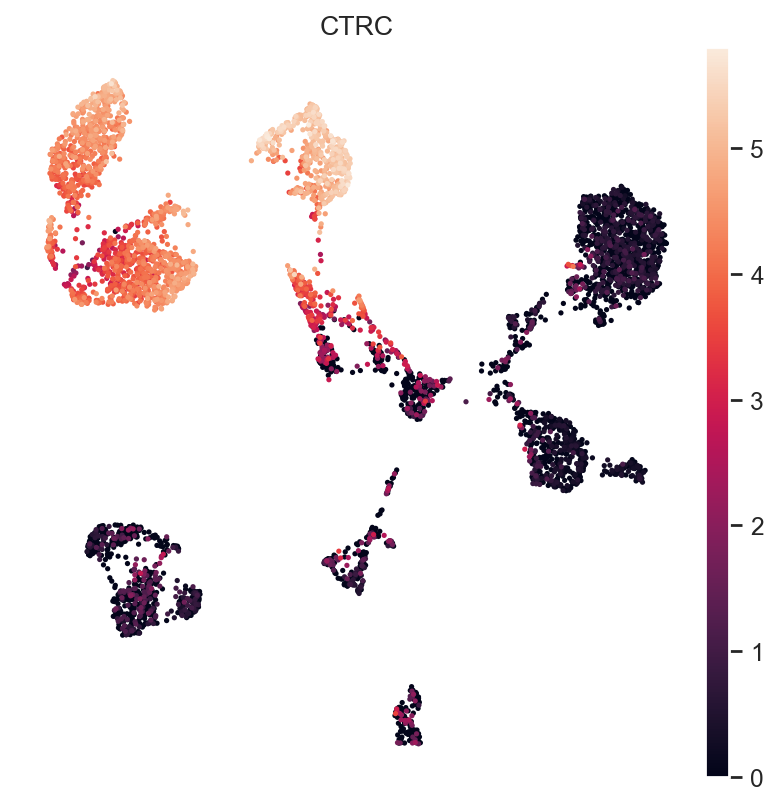

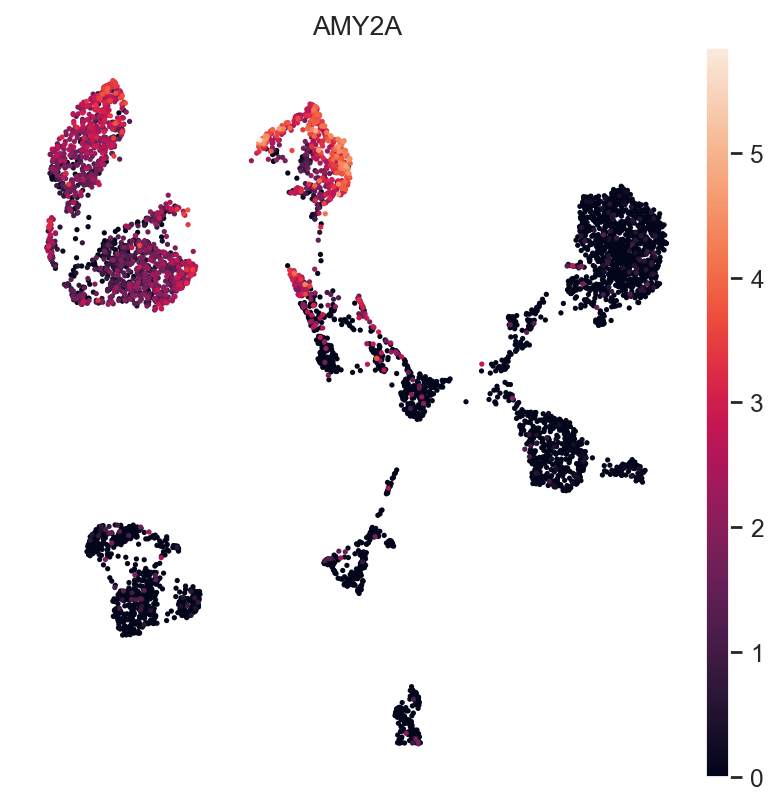

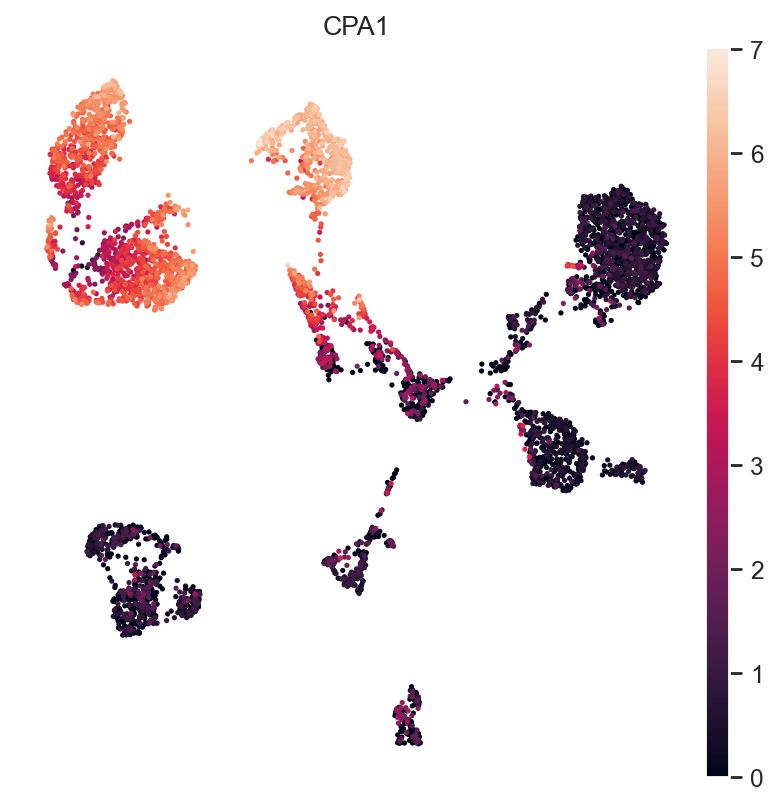

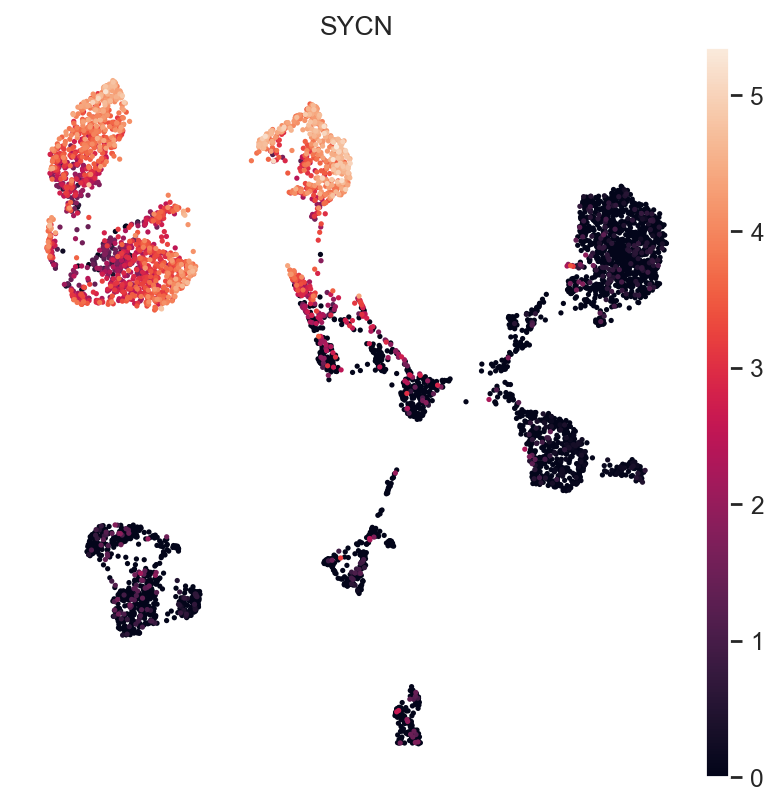

marker gene of Cancer stem cells


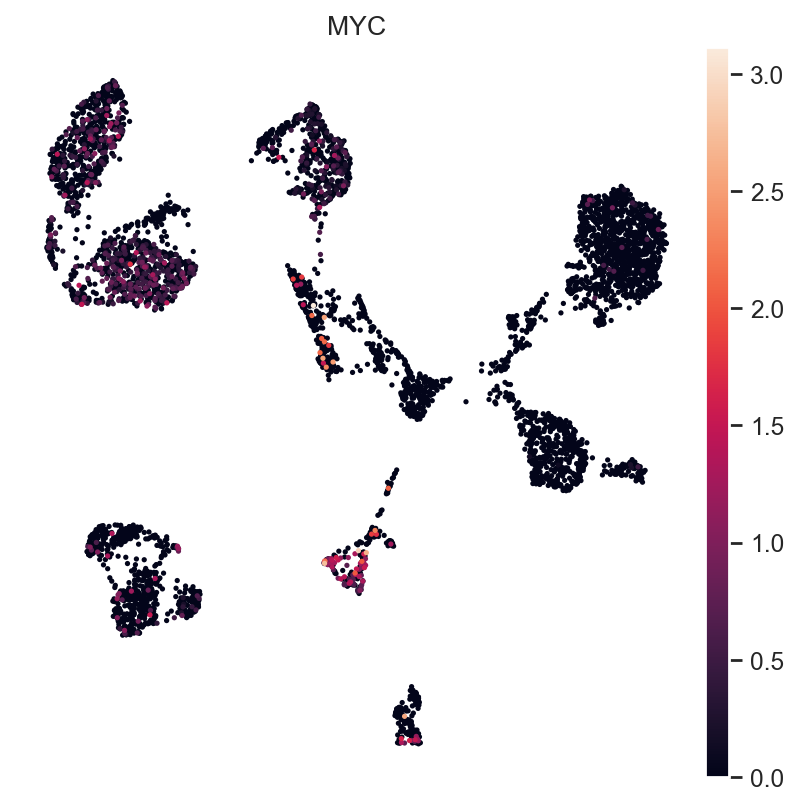

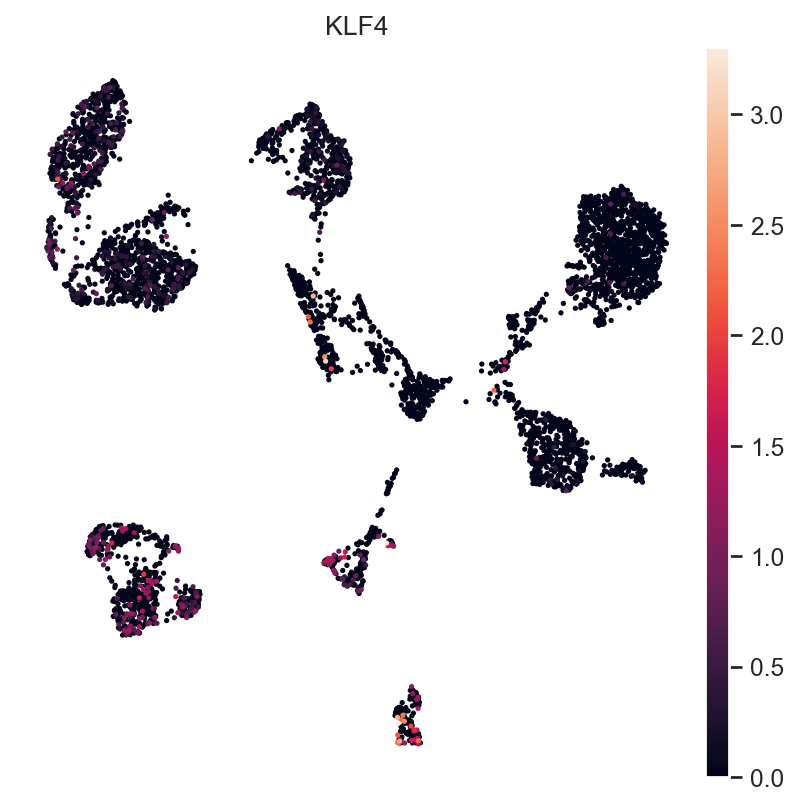

marker gene of Ductal


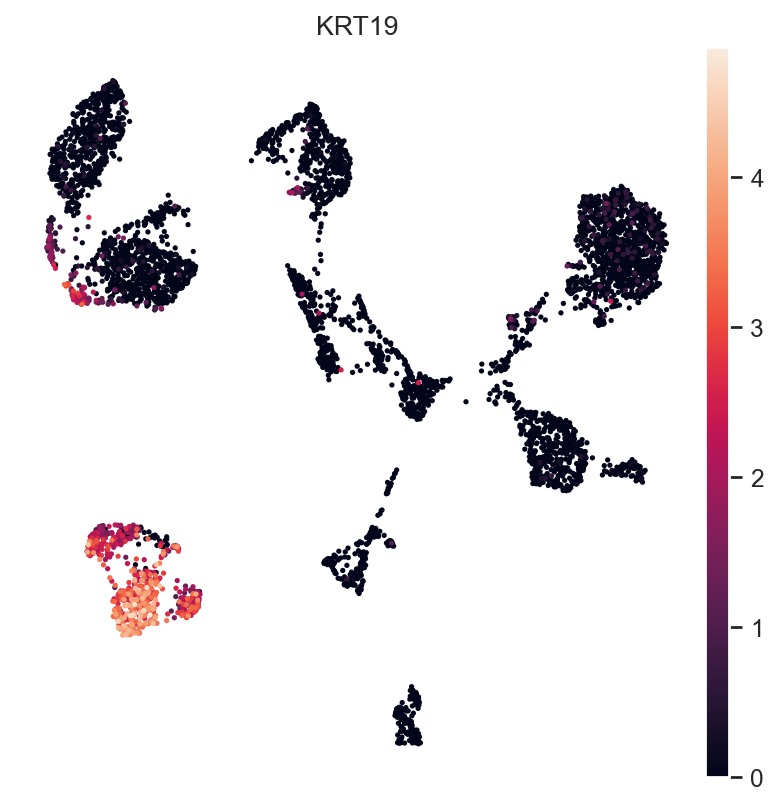

marker gene of Endothelial


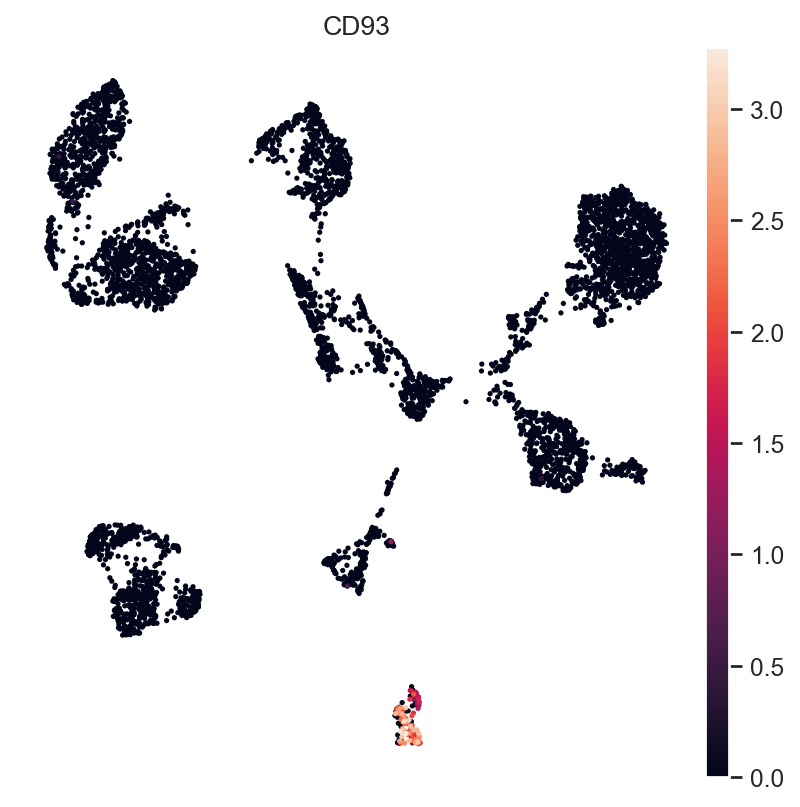

marker gene of Macrophages


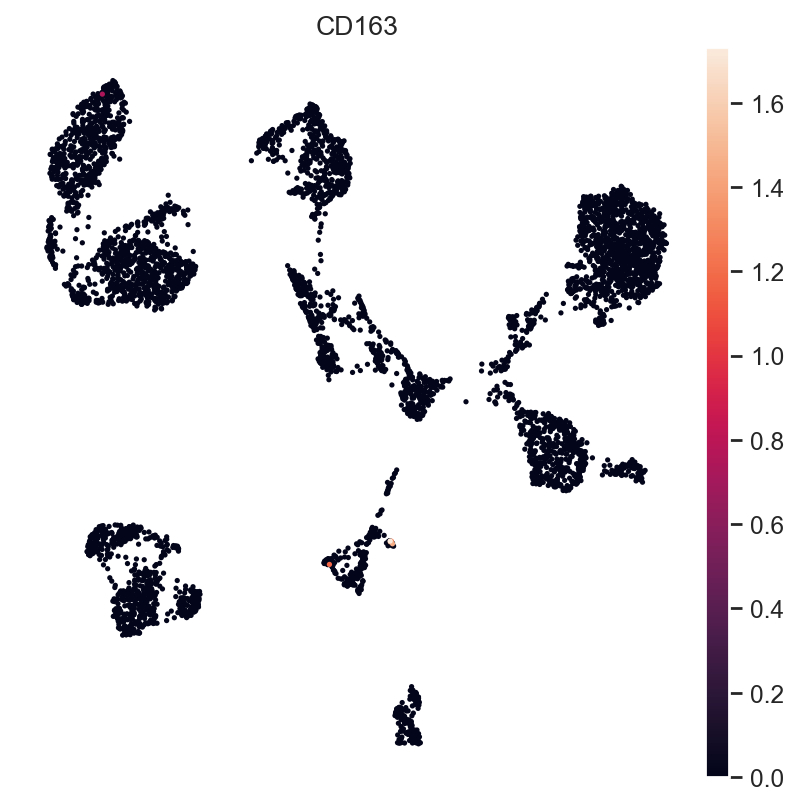

marker gene of PP


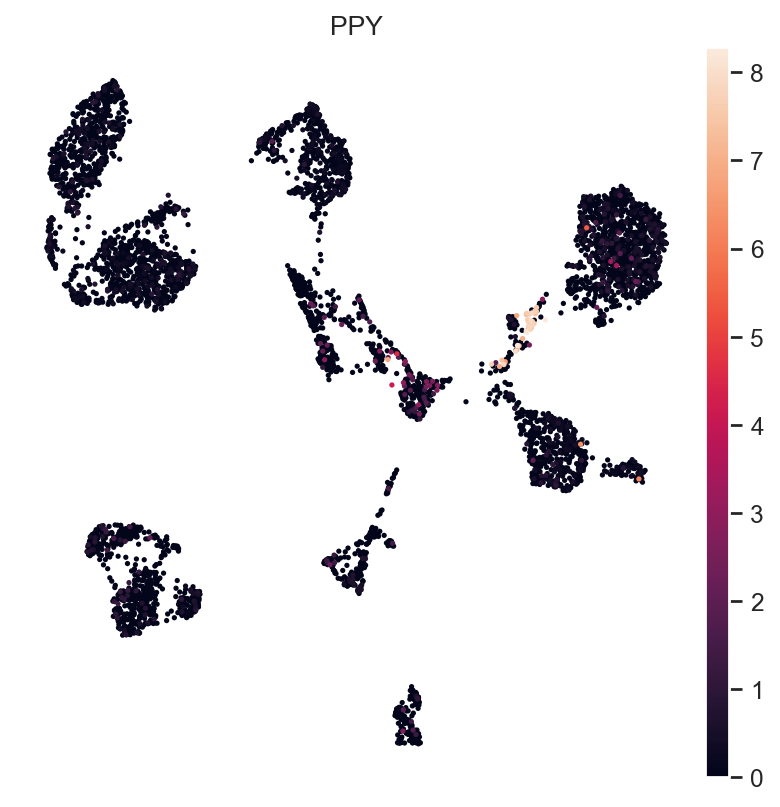

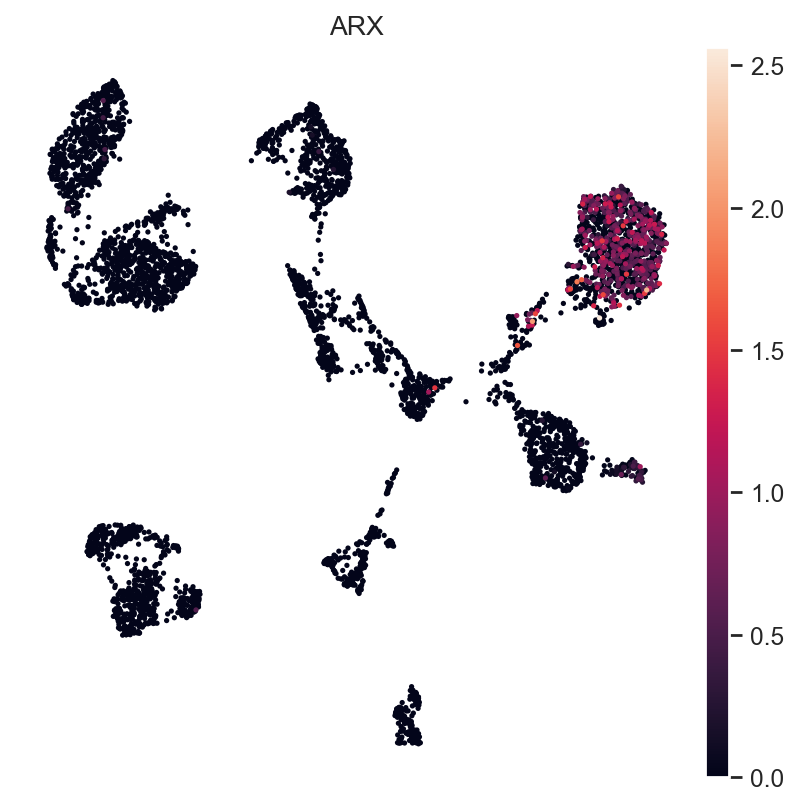

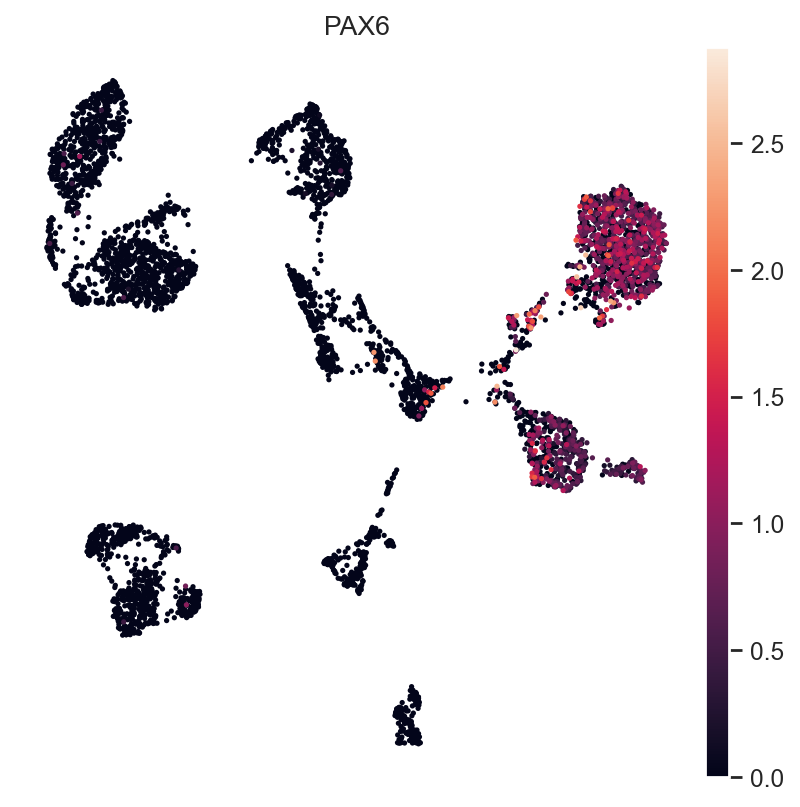

marker gene of Pancreatic progenitor


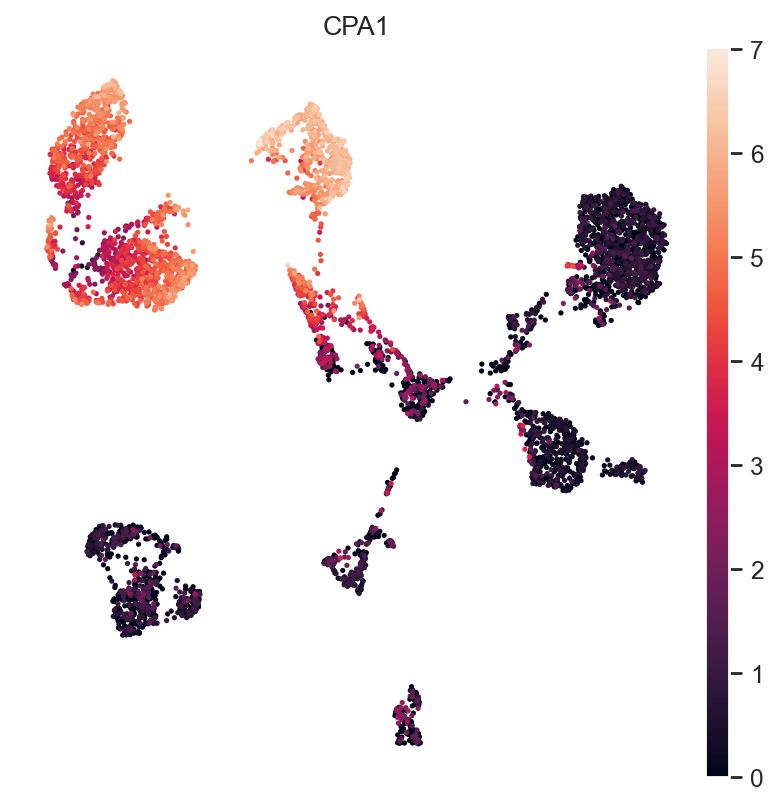

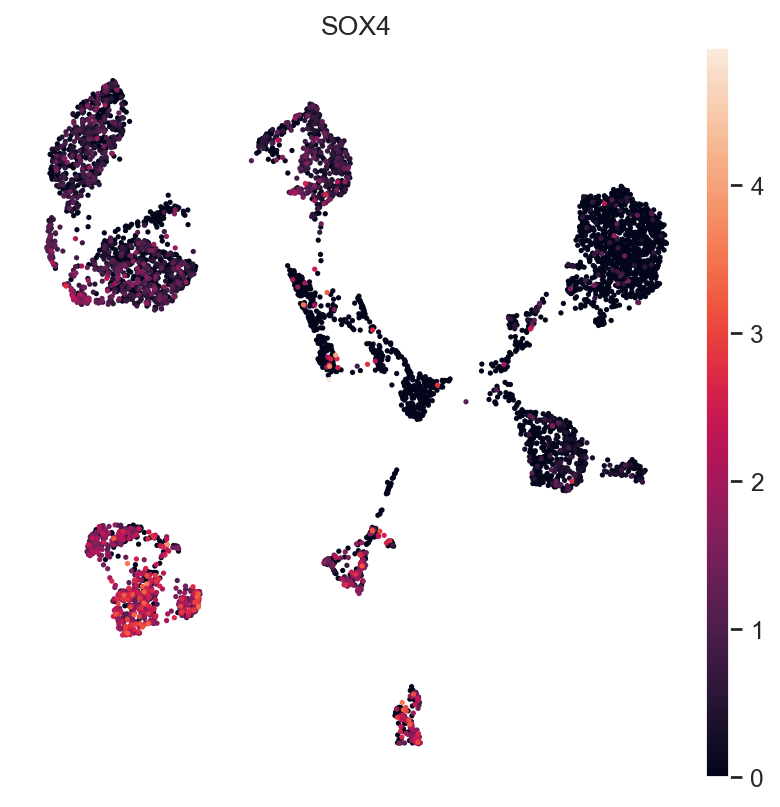

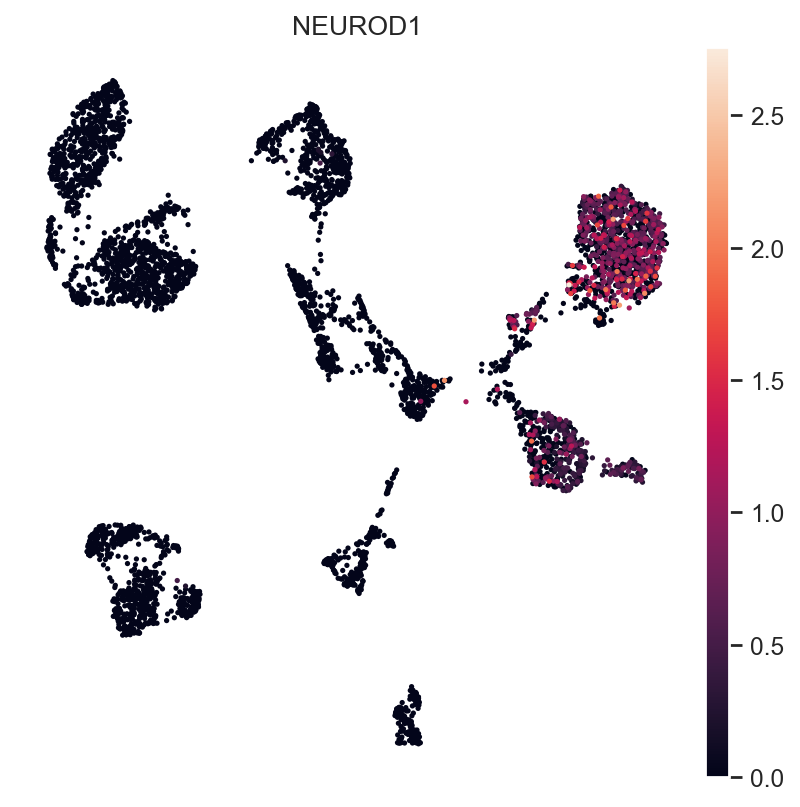

marker gene of Additional factors


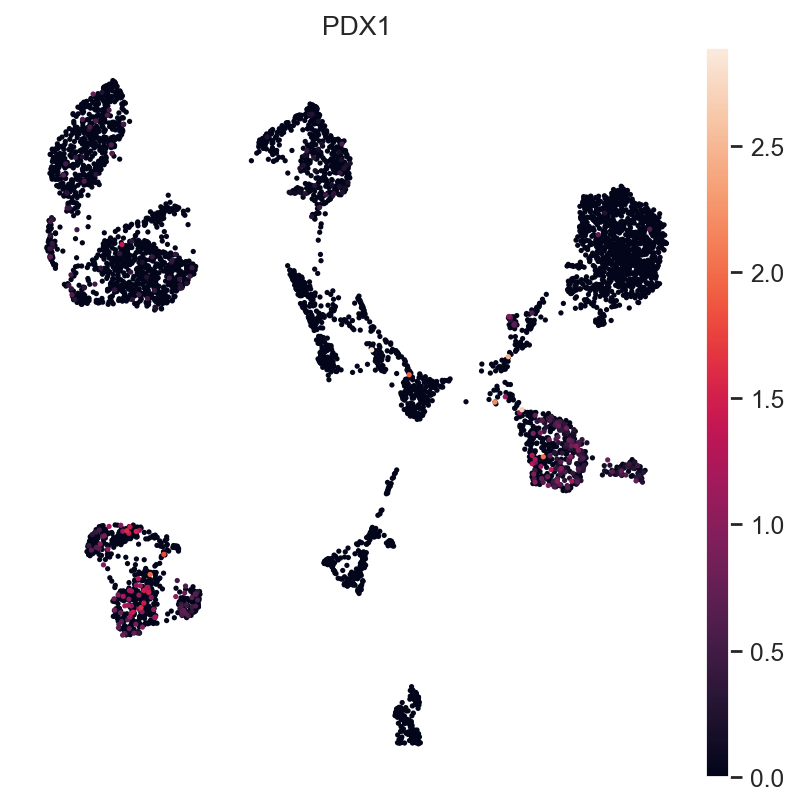

In [457]:
for cell_type, genes in markers.items():
        print(f"marker gene of {cell_type}")
        for gene in genes:
            if gene in adata.var_names:
                sc.pl.umap(adata, color=gene, use_raw=True, ncols=2,save=f'{gene}_expression_umap.png')
                plt.show()
os.rename("figures", "gene_expression")


In [450]:
adata.write("./8human_fetal_sander_lynn_scVI_batch_corrected.h5ad")

In [451]:
adata = sc.read_h5ad("./8human_fetal_sander_lynn_scVI_batch_corrected.h5ad")

KeysView(Layers with keys: counts, scvi_normalized)